**Imports**

In [1]:
import torch
from torch import nn

import pandas as pd
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np 
import random 
import timeit
from tqdm.auto import tqdm

**Hyperparameters**

In [2]:
random_seed = 42

batch_size = 512
num_epochs = 40

learning_rate = 1e-4
num_classes = 46
patch_size = 4
img_size = 32
in_channels = 1
num_heads = 8
dropout = 0.001
hidden_dim = 1024
adam_weight_decay = 0
adam_betas = (0.9, 0.999)
activation = "gelu"
num_encoders = 4
embed_dim = (patch_size ** 2) * in_channels # 16
num_patches = (img_size // patch_size) ** 2 # 64

random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.mps.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


device = "mps" if torch.backends.mps.is_available() else "cpu"

print(f"Device: {device}!")

Device: mps!


In [3]:
from patch_embedding import PatchEmbedding

model = PatchEmbedding(embed_dim, patch_size, num_patches, dropout, in_channels).to(device)

x = torch.randn(512, 1, img_size, img_size).to(device)

print(model(x).shape)

# expected: torch.Size([512, num_patches + 1, embed_dim]) 

torch.Size([512, 65, 16])


In [4]:
from vision_transformer import VisionTransformer
    
model = VisionTransformer(num_patches, img_size, num_classes, patch_size, embed_dim, num_encoders, num_heads, hidden_dim, dropout, activation, in_channels).to(device)

x = torch.randn(512, 1, img_size, img_size).to(device)

print(model(x).shape)

# expected: torch.Size([512, num_classes])

torch.Size([512, 46])


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


**Loading Data**

In [33]:
train_dir = "data/train"
test_dir = "data/test"

In [32]:
train_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.RandomRotation(15), # Random Rotation by 15 degs
    transforms.ToTensor(), # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
    transforms.Normalize([0.5], [0.5])
])
test_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [34]:
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=train_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir, transform = test_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 78200
    Root location: data/train
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 13800
    Root location: data/test
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )


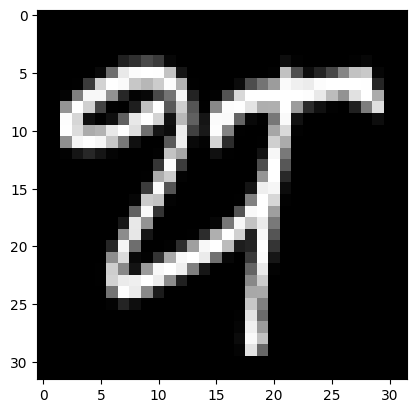

In [42]:
plt.imshow(train_data[13000][0].permute(1, 2, 0), cmap = "gray")

In [35]:
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=batch_size, 
                              shuffle=True) 

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=batch_size,  
                             shuffle=False) 

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x3f466d580>,
 <torch.utils.data.dataloader.DataLoader at 0x3f466d190>)

**Training**

In [50]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), betas = adam_betas, lr = learning_rate, weight_decay = adam_weight_decay)

start = timeit.default_timer()

for epoch in tqdm(range(num_epochs), position = 0, leave = True):
    model.train()
    
    train_labels = []
    train_preds = []
    
    train_running_loss = 0
    
    for idx, img_label in enumerate(tqdm(train_dataloader, position = 0, leave = True)):
        img = img_label[0].float().to(device)
        label = img_label[1].type(torch.uint8).to(device)
        
        y_pred = model(img)
        y_pred_label = torch.argmax(y_pred, dim = 1)
        
        train_labels.extend(label.cpu().detach())
        train_preds.extend(y_pred_label.cpu().detach())
        
        loss = criterion(y_pred, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_running_loss += loss.item()
        
    train_loss = train_running_loss / (idx + 1)
    
    
    if((epoch + 1) % 5 == 0):
        model.eval()

        val_labels = []
        val_preds = []
        val_running_loss = 0

        with torch.no_grad():
            for idx, img_label in enumerate(tqdm(test_dataloader, position = 0, leave = True)):
                img = img_label[0].float().to(device)
                label = img_label[1].type(torch.uint8).to(device)

                y_pred = model(img)
                y_pred_label = torch.argmax(y_pred, dim = 1)

                val_labels.extend(label.cpu().detach())
                val_preds.extend(y_pred_label.cpu().detach())

                loss = criterion(y_pred, label)

                val_running_loss += loss.item()

            val_loss = val_running_loss / (idx + 1)


            print("-"*30)
            print(f"Train loss Epoch {epoch + 1}: {train_loss:.4f}")
            print(f"Valid loss Epoch {epoch + 1}: {val_loss:.4f}")

            print(f"Train Accuracy Epoch {epoch + 1}: {sum(1 for x, y in zip(train_preds, train_labels) if x == y) / len(train_labels):.4f}")
            print(f"Valid Accuracy Epoch {epoch + 1}: {sum(1 for x, y in zip(val_preds, val_labels) if x == y) / len(val_labels):.4f}")
            print("-"*30)
        
stop = timeit.default_timer()

print(f"Training Time: {stop-start:.2f}s")
        

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

------------------------------
Train loss Epoch 5: 2.2123
Valid loss Epoch 5: 2.0307
Train Accuracy Epoch 5: 0.4680
Valid Accuracy Epoch 5: 0.5304
------------------------------


  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

------------------------------
Train loss Epoch 10: 1.8526
Valid loss Epoch 10: 1.6409
Train Accuracy Epoch 10: 0.5425
Valid Accuracy Epoch 10: 0.6140
------------------------------


  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

------------------------------
Train loss Epoch 15: 1.5803
Valid loss Epoch 15: 1.3895
Train Accuracy Epoch 15: 0.5944
Valid Accuracy Epoch 15: 0.6580
------------------------------


  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

------------------------------
Train loss Epoch 20: 1.3992
Valid loss Epoch 20: 1.1939
Train Accuracy Epoch 20: 0.6283
Valid Accuracy Epoch 20: 0.6967
------------------------------


  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

------------------------------
Train loss Epoch 25: 1.2601
Valid loss Epoch 25: 1.0586
Train Accuracy Epoch 25: 0.6584
Valid Accuracy Epoch 25: 0.7213
------------------------------


  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

------------------------------
Train loss Epoch 30: 1.1465
Valid loss Epoch 30: 0.9259
Train Accuracy Epoch 30: 0.6836
Valid Accuracy Epoch 30: 0.7505
------------------------------


  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

------------------------------
Train loss Epoch 35: 1.0569
Valid loss Epoch 35: 0.8631
Train Accuracy Epoch 35: 0.7056
Valid Accuracy Epoch 35: 0.7659
------------------------------


  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

------------------------------
Train loss Epoch 40: 0.9785
Valid loss Epoch 40: 0.7818
Train Accuracy Epoch 40: 0.7219
Valid Accuracy Epoch 40: 0.7841
------------------------------
Training Time: 3249.03s


In [52]:
torch.save(model.state_dict(), f"models/hindi-character-recognition-{num_epochs}epochs")